Combine overlays

- todo: make sure no target areas overlap with the AOI nor national boundary

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
# from shapely.geometry import Point, box, LineString
from shapely import intersection, difference, touches, contains
from tqdm.notebook import tqdm
import os
# import glob

target_epsg = 6350  # https://epsg.org/crs_6350/NAD83-2011-Conus-Albers.html?sessionkey=nb47agmo4r
target_epsg_verbose = "EPSG:6350"

google_epsg = 3857 # web mercator: https://en.wikipedia.org/wiki/Web_Mercator_projection

In [2]:
fn_aoi = '/Volumes/Extreme SSD/largest_plots/clean_data/aoi.parquet'
Aoi = gpd.read_parquet(fn_aoi).rename(columns={'aoi':'aoi_geometry'}).set_geometry('aoi_geometry').set_crs(epsg=target_epsg)

In [3]:
fn_coords = '/Volumes/Extreme SSD/largest_plots/clean_data/coords.parquet'
Coords = gpd.read_parquet(fn_coords).rename(columns={'geometry':'coord_geometry'}).set_geometry('coord_geometry').set_crs(epsg=target_epsg)

In [151]:
fn_water_area_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/water_area_overlay.parquet'
fn_water_linear_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/water_linear_overlay.parquet'
fn_rails_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/rails_overlay.parquet'
fn_nation_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/nation_overlay.parquet'

fn_best_tract_out = '/Volumes/Extreme SSD/largest_plots/clean_data/best_tract.parquet'

def make_road_fn(i: int)  -> str:
    # These are too large to fit into one table, so load each file independently 
    dir_roads_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/road_overlay'
    fn_out = 'road_overlay_' + str(i) + '.parquet'
    dir_fn_out = os.path.join(dir_roads_overlay, fn_out)
    return dir_fn_out

In [5]:
WaterAreaOverlay = gpd.read_parquet(fn_water_area_overlay).set_geometry('water_area_geometry').set_crs(target_epsg)

In [6]:
# Huge file
WaterLinearOverlay = gpd.read_parquet(fn_water_linear_overlay).set_geometry('water_linear_geometry').set_crs(target_epsg)

In [7]:
RailsOverlay = gpd.read_parquet(fn_rails_overlay).set_geometry('rail_geometry').set_crs(target_epsg)

In [8]:
NationOverlay = gpd.read_parquet(fn_nation_overlay).set_geometry('nation_geometry').set_crs(target_epsg)

In [105]:
# i = 150
best_tract_list = []
for i in tqdm(Aoi.index):
    # Note the coordinates of the target point
    
    # areas that are potentially valid
    coord_observation = Coords.loc[[i]]
    aoi_observation = Aoi.loc[[i]]
    nation_observation = NationOverlay.loc[[i]]
    
    # obstructive areas
    water_linear_observation = WaterLinearOverlay.loc[[i]]
    water_area_observation = WaterAreaOverlay.loc[[i]]
    rail_observation = RailsOverlay.loc[[i]]
    road_observation = gpd.read_parquet( make_road_fn(i) ).set_geometry('road_geometry').set_crs(target_epsg)

    # Find intersection between the area of interest and the national coastline
    potential = gpd.overlay(aoi_observation, nation_observation, how='intersection', keep_geom_type=True, make_valid=True)
    
    # Collect all obstructions, flatten them into one layer
    obstruction_series = pd.concat([
        water_linear_observation.rename(columns={'water_linear_geometry':'geometry'}),
        water_area_observation.rename(columns={'water_area_geometry':'geometry'}),
        rail_observation.rename(columns={'rail_geometry':'geometry'}),
        road_observation.rename(columns={'road_geometry':'geometry'})
    ])
    obstruction = gpd.GeoDataFrame(obstruction_series).dissolve()
    
    # remove obstructions from potential; explode so that each segment of the multipolygon is now a simple polygon, one per row
    remaining_potential = potential.difference(obstruction)
    ExplodedRemainingPotential = gpd.GeoDataFrame({'geometry':list(remaining_potential.loc[0].geoms)}, crs=target_epsg_verbose)
    
    # Find closest shape to point (could contain point). 
    #Note that this will include tracts close to, but not containing, the point-- 
    #this is intentional, to account for the inexact nature of some of the assumptions that got us here (eg width of rivers)
    DistanceOfRemainingPotentialsToCoords = gpd.sjoin_nearest(ExplodedRemainingPotential, coord_observation, 
                                                              distance_col="distance", lsuffix="remaining_potential", 
                                                              rsuffix="coord", how='left', exclusive=False)
    
    # Save the results
    BestTract = DistanceOfRemainingPotentialsToCoords.sort_values('distance', ascending=True).head(1)[['geometry', 'distance']]
    BestTract['aoi_index'] = i
    BestTract = BestTract.set_index('aoi_index')
    best_tract_list.append(BestTract)

  0%|          | 0/231 [00:00<?, ?it/s]

# Write to disk

In [167]:
BestTracts = pd.concat(best_tract_list)
BestTracts = BestTracts.rename(columns={'geometry':'best_tract_geometry', 'distance':'distance_m'})
BestTracts = BestTracts.set_geometry('best_tract_geometry').set_crs(target_epsg)
BestTracts['area_m'] = BestTracts.area
BestTracts['does_tract_contain_coord'] = BestTracts['distance_m'] == 0
BestTracts.sort_values('aoi_index').to_parquet(fn_best_tract_out)
BestTracts

best_tract_geometry  distance_m  \
aoi_index                                                                  
0          POLYGON ((1564529.635 1875053.603, 1564528.981...         0.0   
1          POLYGON ((1596172.747 1826351.496, 1596143.566...         0.0   
2          POLYGON ((922468.509 1216735.038, 922407.093 1...         0.0   
3          POLYGON ((573735.600 965305.976, 573737.559 96...         0.0   
4          POLYGON ((1035487.754 1715764.931, 1035489.830...         0.0   
...                                                      ...         ...   
226        POLYGON ((637988.154 2136592.773, 637987.097 2...         0.0   
227        POLYGON ((682675.044 2076569.795, 682665.949 2...         0.0   
228        POLYGON ((564877.851 2159431.565, 564885.432 2...         0.0   
229        POLYGON ((1829880.385 2104784.777, 1829896.894...         0.0   
230        POLYGON ((153753.368 1460832.873, 153735.444 1...         0.0   

                 area_m  does_tract_contain_coord  
aoi_index                                          
0          8.275338e+05                      True  
1          2.159902e+05                      True  
2          4.148185e+06                      True  
3          8.109797e+06                      True  
4          9.675407e+06                      True  
...                 ...                       ...  
226        8.972320e+05                      True  
227        1.762155e+06                      True  
228        4.941363e+05                      True  
229        8.120913e+05                      True  
230        2.205352e+06                      True  

[231 rows x 4 columns]

# Optional QC

In [159]:
# Most of the tracts contain the points
qq = np.arange(0, 1.2, step=0.2)
BestTracts.distance_m.quantile(qq)

0.0     0.000000
0.2     0.000000
0.4     0.000000
0.6     0.000000
0.8     0.000000
1.0    28.898856
Name: distance_m, dtype: float64

In [164]:
(BestTracts.distance_m == 0).sum()

227

In [162]:
(BestTracts.distance_m > 0).sum()

4

In [146]:
# Do any of the AOIs artificially clip the best tracts? 
TractAndAoi = BestTracts.join(Aoi)
TractAndAoi['best_tract_geometry'].overlaps(TractAndAoi['aoi_geometry']).sum()

0

In [147]:
# Are the indices of BestTracts and AOI identical? ie no missing values, no duplicates
sorted(BestTracts.index.values) == sorted(Aoi.index.values)

True

In [148]:
# all of the indices occur only once
BestTracts.index.value_counts().value_counts()

count
1    231
Name: count, dtype: int64

<Axes: >

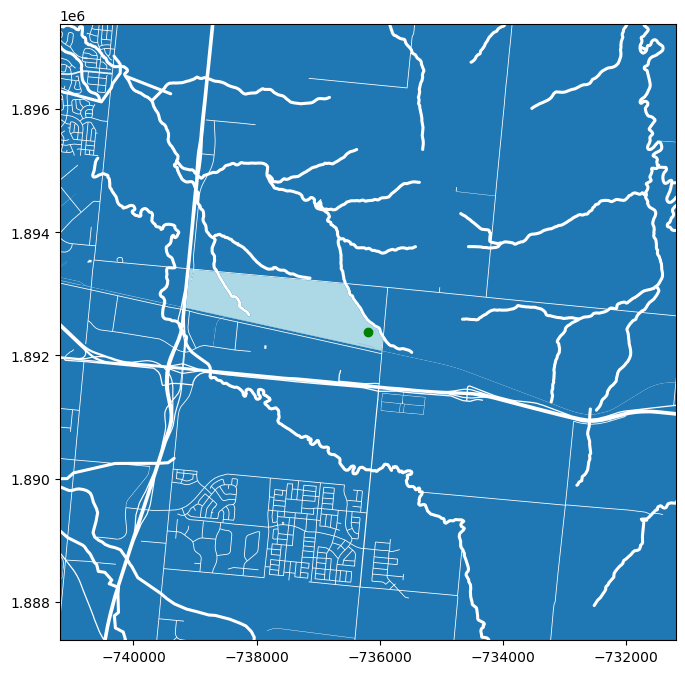

In [95]:
# QC for any given files from the above for-loop
# fig, ax = plt.subplots(figsize=(8, 8))

# minx, miny, maxx, maxy = coord_observation.buffer(distance=5*1e3).bounds.iloc[0].tolist()
# ax.set_xlim([minx, maxx])
# ax.set_ylim([miny, maxy])

# ExplodedRemainingPotential.plot(ax=ax)
# DistanceOfRemainingPotentialsToCoords.sort_values('distance').head(1).plot(ax=ax, color='lightblue')
# coord_observation.plot(ax=ax, color='green')